# Projet Machine Learning : Détection des tempêtes solaires
par Ouriane Aissou et Rayann HAMROUNI

# Introduction
Le but ce projet est de concevoir un algorithme permettant de détecter les Ejections de Masse Coronale Interplanétaires (EMCI) à partir d'une base de données contenant 657 événements de tempêtes solaires. Nous avons accès à un sous-ensemble de la base de donnée. Ce sous-ensemble composé d'une base d'apprentissage allant de 1997 à 2007 et d'une base de test de 2008 à 2011 va nous permettre de calibrer et de tester l'algorithme que nous allons utiliser pour prédire la partie restante de la base de données(allant de 2012 à 2015). Cette base de données est aussi constituée de  mesures de données récoltées sur place par la sonde WIND entre 1997 et 2016,  échantillonnées à une résolution de 10 minutes et pour lesquelles ont été calculées trois caractéristiques supplémentaires qui se sont révélées utiles pour l'identification visuelle des EMCI. Au total, 33 variables sont à notre disposition et ont pour but d'expliquer l'arrivée de tempêtes solaires représentées par une variable binaire (0 pour le vent solaire, 1 pour la tempête solaire). Cependant, cette variable ne peut expliquer à elle seule une tempête solaire en ce que cette dernière ne se résume pas en un pic qui apparait et disparait aussitot. Une tempête solaire est un évennement qui existe avec une certaine durée. Les périodes consécutives où la variable binaire est égale à 1 sont considérées comme 1 événement.
Les événements distants de moins de 1 heure sont fusionnés et les événements de moins de 2 heures et demi sont supprimés. L'objectif attendu de notre algorithme est qu'il diminue le taux de faux positifs(en dessous de 10%), tout en détectant le plus d'évenements que possible(maximisation du taux de recall avec une contrainte de 90% du taux de précision). L'algorithme utilisé jusqu'alors (Régression Logistique) n'a pas permis de remplir ces critères. En effet, celui-ci a un taux de recall (pour les évenements) de 6% seulement pour une précision de 20% sur la base de test. 
A travers ce rapport, nous allons cherché à montrer l'ensemble des raisonnements qui nous ont permis d'améliorer ce score.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Présentation de la Base de données

In [3]:
from problem import get_train_data

data_train, labels_train = get_train_data()

In [4]:
X = data_train

In [5]:
describe=X.describe()
describe['Range F 14']

count    509834.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Range F 14, dtype: float64

Nous observons ici que la variable "Range F 14" est composée à 100% de valeurs manquantes ou nulles. Cette colonne ne nous est donc d'aucune utilité pour l'estimation à venir de notre modèle

## Analyse des données : Analyse en Composante principales

A travers cette partie, nous avons cherché à fournir une analyse préalable des données. L'intuition que nous avions était qu'il existait un grand nombre de variable dont l'existence n'était pas forcément justifiée. Nous en voulons pour preuve le fait d'y retenir la variable "Range F 14" composée uniquement de valeurs manquantes. Cela implique que la base de données n'a pas totalement été traitée au préalable et que certaines variables relevées par la sonde WIND ne rajouteraient que peu d'informations au modèle, voire pas du tout. 
Dans ce contexte, nous avons décidé d'opter pour une Analyse en Composante Principale de la base de données contenant les variables exogènes. 
L'ACP aura pour utilité de nous permettre 3 choses:
- Analyser les corrélations entre les différentes variables
- Supprimer les variables trop fortement corrélés afin d'éliminer les potentiels risques de colinéarités.
- Réduire la dimensionnalité et simplifier ainsi l'explication des évenements (Cette dernière peut aussi avoir pour but de réduire l'overfitting, bien que le nombre d'observations à notre disposition nous pemet d'échapper totalement à tout problème de dimmensionnalité).

In [278]:
from sklearn.preprocessing import StandardScaler 

In [279]:
sc = StandardScaler()

In [280]:
X = data_train
Z = sc.fit_transform(X)
from sklearn.decomposition import PCA
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)
eigval = (len(X)-1)/len(X)*acp.explained_variance_

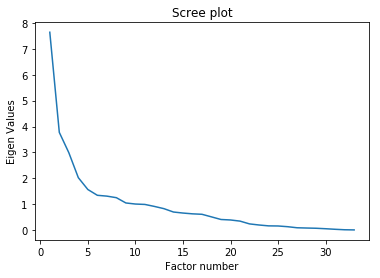

In [281]:
p=len(Z[0])
plt.plot(np.arange(1, p+1), eigval)
plt.title("Scree plot")
plt.ylabel("Eigen Values")
plt.xlabel("Factor number")
plt.show()

Avec l'approche de la Singular Value Decomposition (SVD), nous avons obtenu les valeurs propres de la matrice de variance covariance maximisée de la base train. Nous observons grâce à cela que passé les 5 premières composantes, les valeurs propres associées aux composantes ont une valeur de plus en plus stable. Cela implique que passé, les 5 premières composantes, les composantes restantes ajouteront peu d'explication à la variance globale. En effet, nous pouvons voir à partir du graphique ci-dessous que les 5 premières composantes expliquent à elles seules plus de 50 % de la matrice de Variance Covariance.

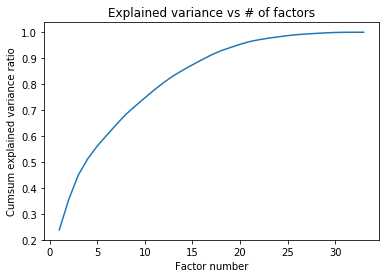

In [282]:
plt.plot(np.arange(1, p+1), np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [283]:
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))

for k in range(p):
    corvar[:, k] = acp.components_[k, :] * sqrt_eigval[k]

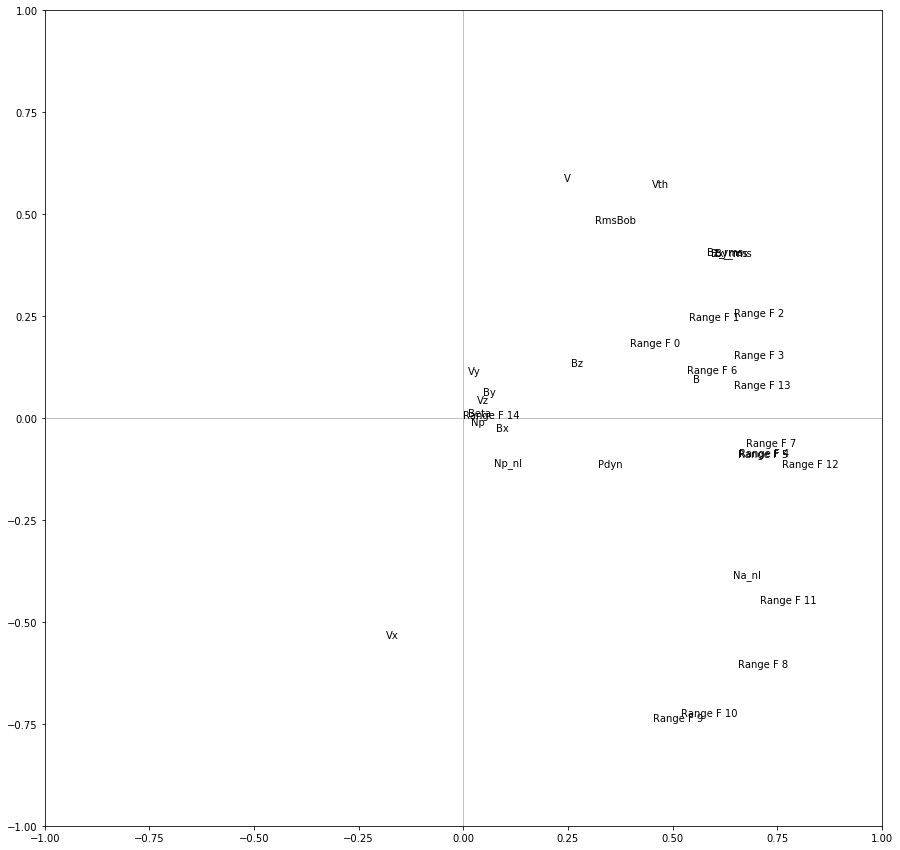

In [284]:
fig, axes = plt.subplots(figsize = (15, 15))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

for j in range(p):
    plt.annotate(X.columns[j], (corvar[j, 0], corvar[j, 1]))
    
plt.plot([-1,1], [0,0], color = 'silver', linestyle = '-', linewidth = 1)
plt.plot([0,0], [-1, 1], color = 'silver', linestyle = '-', linewidth = 1)

On peut remarquer qu'il y a beaucoup de variables qui sont corrélés entre elles. Nous décidons de supprimer parmi un tuple de n variables corrélées n-1 variables corrélées entre elles.

In [300]:
var_supr = ['By_rms',
            'Range F 1', 'Range F 11', 'Pdyn',
            'Np_nl', 'Bx', 'Np', 'By',
           'Vz', 'Vy', 'Range F 14', 'B',
           'Range F 0', 'Range F 6', 'Bx_rms', 'Bz','Range F 4', 'Range F 10', 'Range F 12', 'Range F 7', 'Range F 3' ]

In [286]:
X = X.drop(var_supr, axis = 1)
Z = sc.fit_transform(X)
from sklearn.decomposition import PCA
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)
eigval = (len(X)-1)/len(X)*acp.explained_variance_

In [287]:
p=len(Z[0])

In [288]:
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))

for k in range(p):
    corvar[:, k] = acp.components_[k, :] * sqrt_eigval[k]

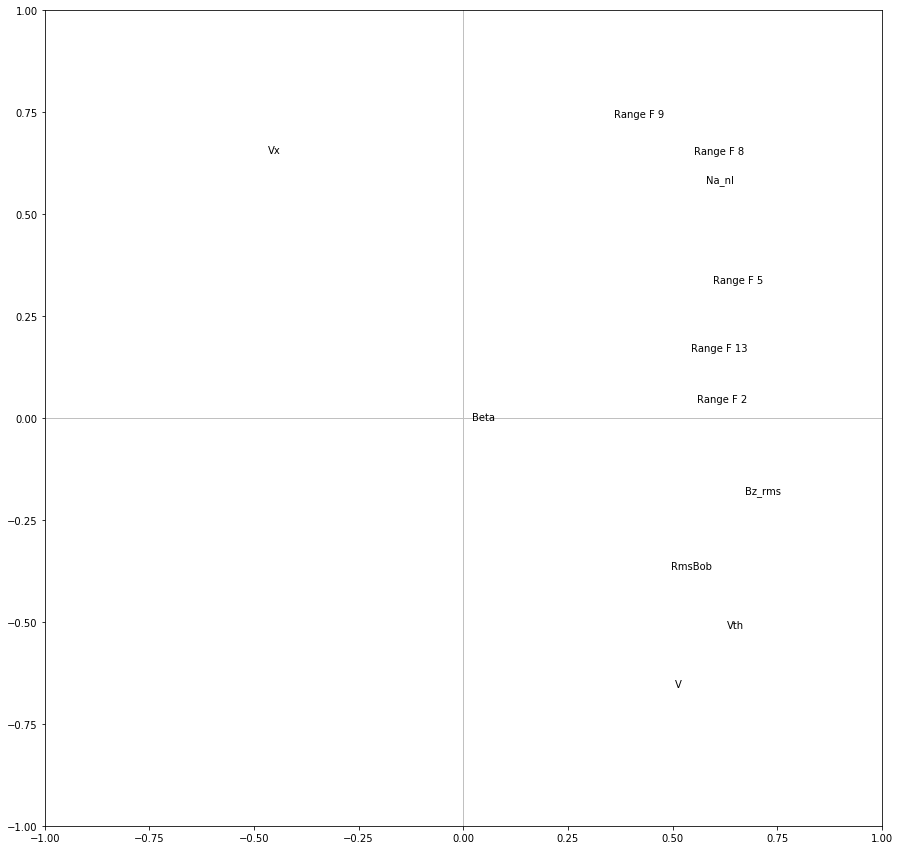

In [289]:
fig, axes = plt.subplots(figsize = (15, 15))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

for j in range(p):
    plt.annotate(X.columns[j], (corvar[j, 0], corvar[j, 1]))
    
plt.plot([-1,1], [0,0], color = 'silver', linestyle = '-', linewidth = 1)
plt.plot([0,0], [-1, 1], color = 'silver', linestyle = '-', linewidth = 1)

## Visualisation des données

In [6]:
X.head()

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
1997-10-01 00:00:00,6.584763,3.753262,2.303108,0.966140,2.602693,-5.179685,2.668414,2.290824,23.045732,24.352797,...,2.757919e+09,2.472087e+09,378.313934,80.613098,-351.598389,-138.521454,6.956387,7.641340,5.487331e-15,0.668473
1997-10-01 00:10:00,6.036456,0.693559,1.810752,-0.904843,2.165570,-1.944006,2.372931,2.119593,23.000492,20.993362,...,3.365612e+09,3.087122e+09,350.421021,69.919327,-331.012146,-110.970787,-21.269474,9.149856,4.783776e-15,0.753848
1997-10-01 00:20:00,5.653682,-4.684786,0.893058,-2.668830,0.768677,1.479302,1.069266,2.876815,20.676191,17.496399,...,1.675611e+09,1.558640e+09,328.324493,92.194435,-306.114899,-117.035202,-13.018987,11.924199,3.719768e-15,0.282667
1997-10-01 00:30:00,5.461768,-4.672382,1.081638,-2.425630,0.765681,1.203713,0.934445,2.851195,20.730188,16.747108,...,1.589037e+09,1.439569e+09,319.436859,94.230705,-298.460938,-110.403969,-20.350492,16.032987,3.525211e-15,0.304713
1997-10-01 00:40:00,6.177846,-5.230110,1.046126,-2.872561,0.635256,1.505010,0.850657,3.317076,20.675701,17.524536,...,1.812308e+09,1.529260e+09,327.545929,89.292595,-307.303070,-111.865845,-12.313167,10.253789,3.694283e-15,0.244203


In [7]:
def plot_event(start, end, data, delta=36):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    subset = data[(start - pd.Timedelta(hours=delta)):(end + pd.Timedelta(hours=delta))]
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,15), sharex=True)
    
   # plot 1
    axes[0].plot(subset.index, subset['B'], color='gray', linewidth=2.5)
    axes[0].plot(subset.index, subset['Bx'])
    axes[0].plot(subset.index, subset['By'])
    axes[0].plot(subset.index, subset['Bz'])
    axes[0].legend(['B', 'Bx', 'By', 'Bz (nT)'],loc='center left', bbox_to_anchor=(1, 0.5))
    axes[0].set_ylabel('Magnetic Field (nT)')

    # plot 2
    axes[1].plot(subset.index, subset['Beta'], color='gray')
    axes[1].set_ylim(-0.05, 1.7)
    axes[1].set_ylabel('Beta')

    # plot 3
    axes[2].plot(subset.index, subset['V'], color='gray')
    axes[2].set_ylabel('V(km/s)')
    #axes[2].set_ylim(250, 500)
    
    # plot 4
    axes[3].plot(subset.index, subset['Vth'], color='gray')
    axes[3].set_ylabel('$V_{th}$(km/s)')
    #axes[3].set_ylim(5, 60)

    # add vertical lines
    for ax in axes:
        ax.axvline(start, color='k')
        ax.axvline(end, color='k')
        ax.xaxis.grid(True, which="minor")
    
    return fig, axes

In [9]:
from problem import turn_prediction_to_event_list
events = turn_prediction_to_event_list(labels_train)
events

[Event(1997-10-01 13:40:00 ---> 1997-10-03 08:00:00),
 Event(1997-10-10 22:00:00 ---> 1997-10-11 23:20:00),
 Event(1997-10-27 10:30:00 ---> 1997-10-27 18:30:00),
 Event(1997-10-27 21:00:00 ---> 1997-10-28 05:00:00),
 Event(1997-11-07 05:30:00 ---> 1997-11-08 22:50:00),
 Event(1997-11-22 19:00:00 ---> 1997-11-23 18:20:00),
 Event(1997-11-24 00:00:00 ---> 1997-11-24 21:00:00),
 Event(1997-11-30 18:00:00 ---> 1997-12-01 03:40:00),
 Event(1997-12-10 18:40:00 ---> 1997-12-12 23:50:00),
 Event(1997-12-13 03:00:00 ---> 1997-12-14 01:00:00),
 Event(1997-12-14 05:50:00 ---> 1997-12-14 16:50:00),
 Event(1997-12-30 09:50:00 ---> 1997-12-31 08:40:00),
 Event(1998-01-07 02:50:00 ---> 1998-01-07 19:40:00),
 Event(1998-01-07 21:40:00 ---> 1998-01-08 09:20:00),
 Event(1998-01-08 15:50:00 ---> 1998-01-08 22:20:00),
 Event(1998-01-09 09:20:00 ---> 1998-01-09 20:40:00),
 Event(1998-01-18 10:00:00 ---> 1998-01-19 19:50:00),
 Event(1998-01-20 18:00:00 ---> 1998-01-21 03:00:00),
 Event(1998-01-21 05:10:00 -

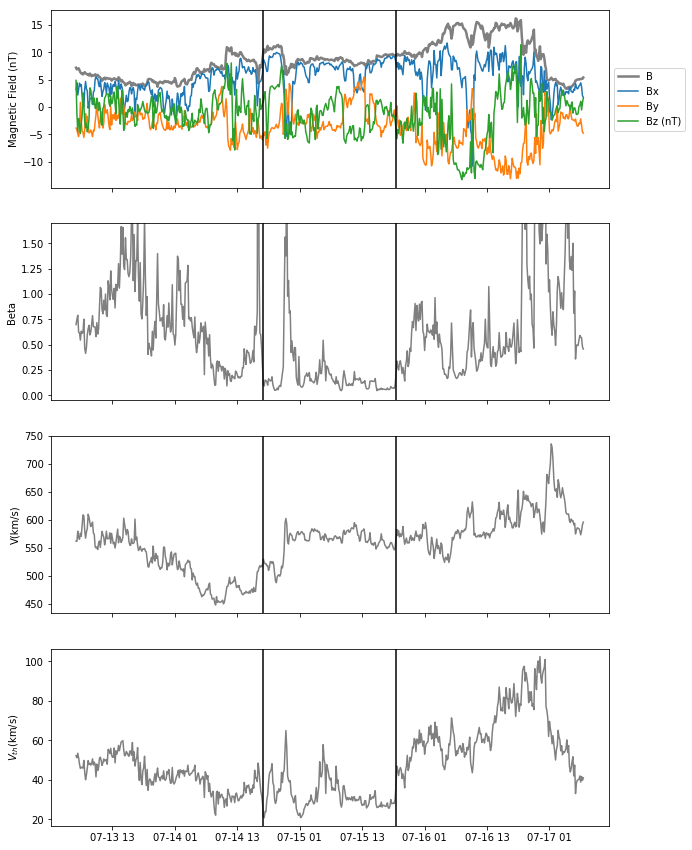

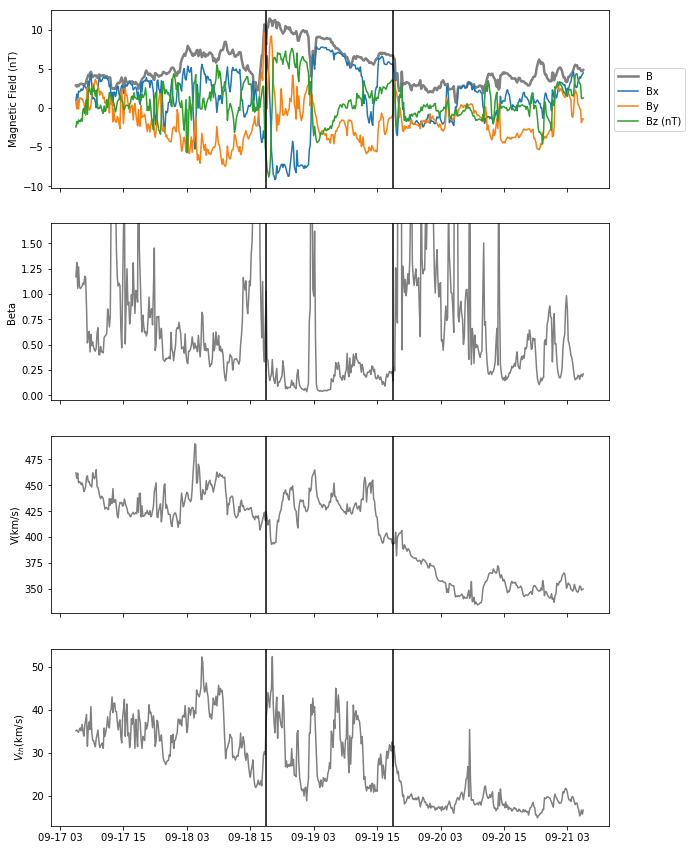

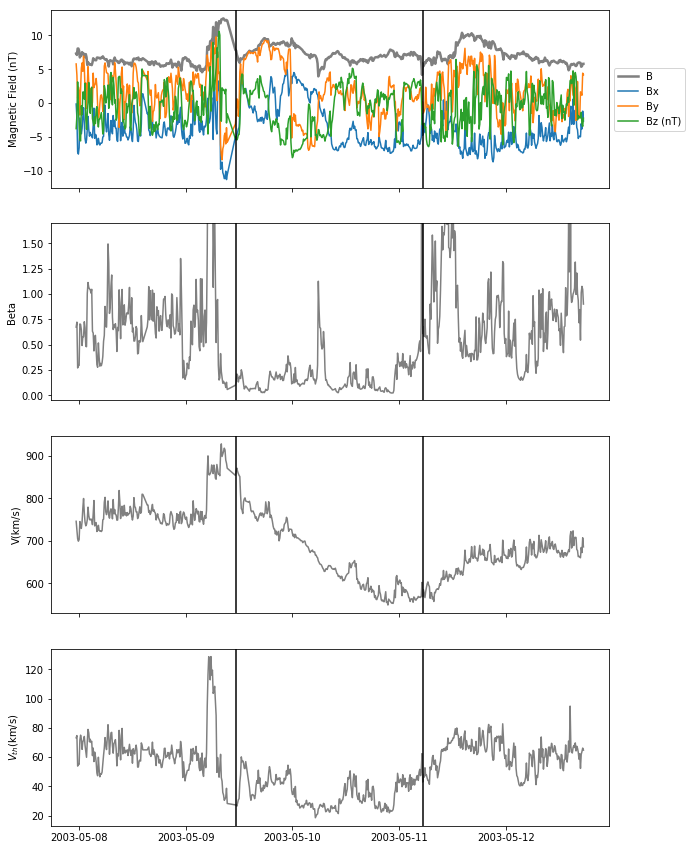

In [10]:
rng = np.random.RandomState(1234)

for i in rng.randint(0, len(events), 3):
    plot_event(events[i].begin, events[i].end, data_train)

Nous cherchons ici à représenter l'evolution des principales variables dont on estime qu'elles ont un impact significatif sur la venue de tempêtes solaires. Il s'agit ici de 3 évènements pris aléatoirement dans la base de données. Nous représenons l'évolution de ces variables 36 heures avant et après l'évenement, ainsi que pendant l'évenement. Nous pouvons observer que les relevés ayant trait aux champs magnétiques globaux, au paramètre de plasma(Beta), à la vélocité globale et à la vitesse thermique se comportent différemment pendant l'évenement qu'en dehors de celui-ci

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def plot_distrib(start, end, data):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    subset = data[(start):(end)]
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=False)
    sns.kdeplot(subset['B'],color="b",shade = True,  ax=axes[0,0])
    sns.kdeplot(subset['Bx'], color="y",shade = True,  ax=axes[0,1])
    sns.kdeplot(subset['By'], color="k",shade = True,  ax=axes[0,2])
    sns.kdeplot(subset['Bz'],color="m",shade = True,  ax=axes[1,0])
    sns.kdeplot(subset['Beta'], color="r", shade = True,  ax=axes[1,1])
    sns.kdeplot(subset['V'], color="c", shade = True , ax=axes[1,2])
    sns.kdeplot(subset['Vth'], color="g",shade = True , ax=axes[2,0])
    return fig, axes

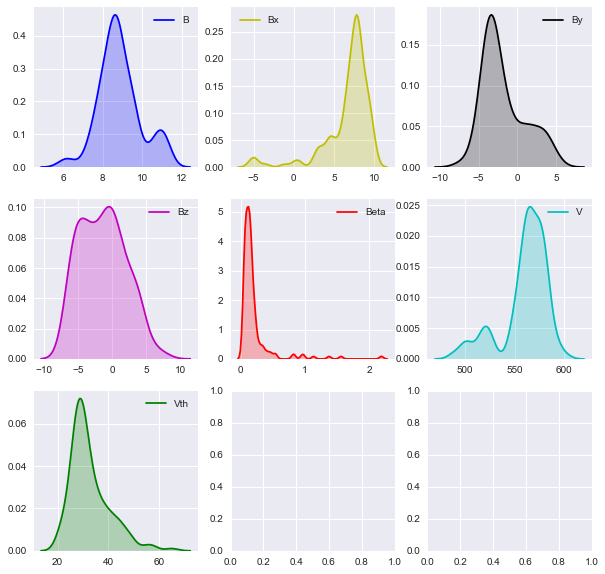

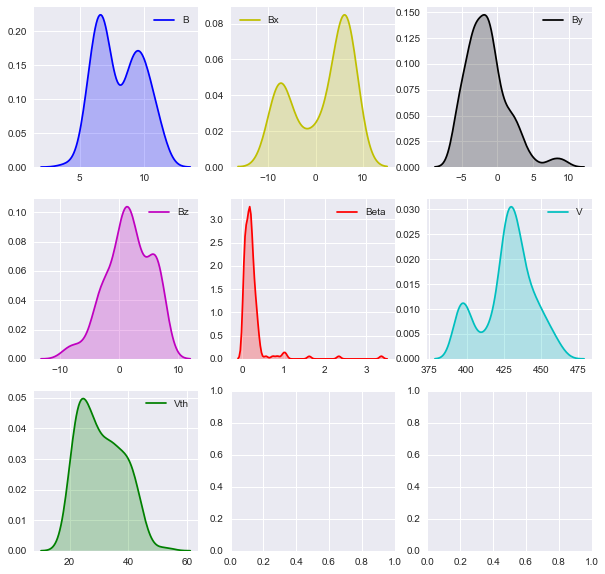

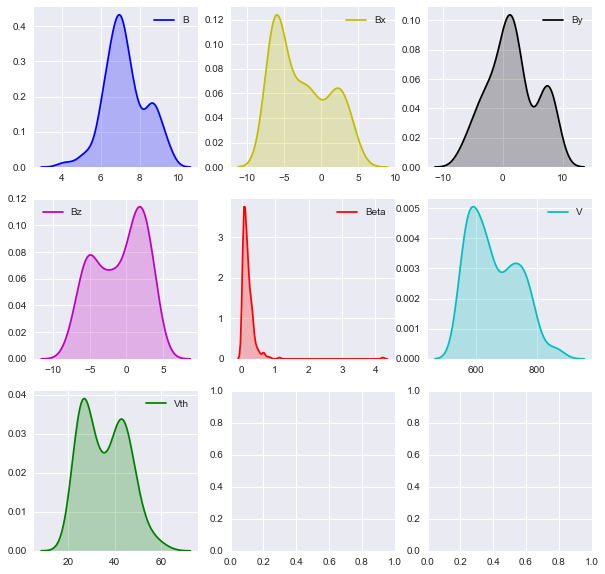

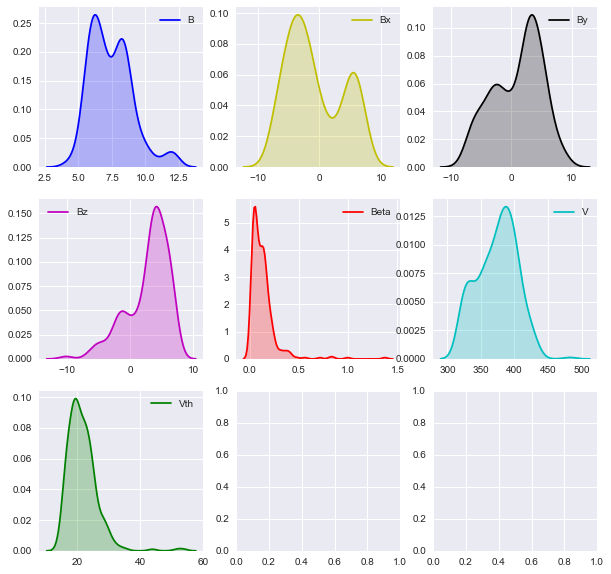

In [12]:
rng = np.random.RandomState(1234)

for i in rng.randint(0, len(events), 4):
    plot_distrib(events[i].begin, events[i].end, data_train) 

Nous avons cherché à représenter la distribution des mêmes variables pendant 4 évenements choisis aléatoirement. Nous obsevons ici que leur distribution est assez anormale.


In [13]:
duration = [ev.end - ev.begin for ev in events]
duration = pd.Series(duration).dt.total_seconds() / 60 / 60
maxi=duration.max()
mean=duration.mean()
mini=duration.min()
print(maxi,mini,mean)

93.5 2.5 23.512135922330103


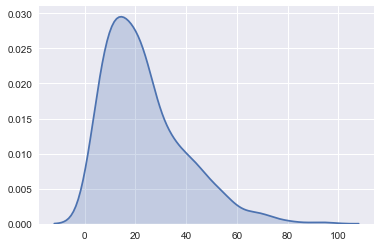

In [14]:
sns.kdeplot(duration, shade = True)

Ici, nous avons cherché à calculer la durée des évenements de la base d'apprentissage. Nous observons sa distribution et pouvons voir que la durée moyenne d'un évenement est d'approximativement 24 heures, la durée minimale de 2 heures et demi et la durée maximale de 93 heures et demi.

In [17]:
from problem import get_test_data

data_test, labels_test = get_test_data()

In [18]:
X_test = data_test.drop(var_supr, axis=1)
X_train = data_train.drop(var_supr, axis=1)

In [19]:
X.head()

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
1997-10-01 00:00:00,6.584763,3.753262,2.303108,0.966140,2.602693,-5.179685,2.668414,2.290824,23.045732,24.352797,...,2.757919e+09,2.472087e+09,378.313934,80.613098,-351.598389,-138.521454,6.956387,7.641340,5.487331e-15,0.668473
1997-10-01 00:10:00,6.036456,0.693559,1.810752,-0.904843,2.165570,-1.944006,2.372931,2.119593,23.000492,20.993362,...,3.365612e+09,3.087122e+09,350.421021,69.919327,-331.012146,-110.970787,-21.269474,9.149856,4.783776e-15,0.753848
1997-10-01 00:20:00,5.653682,-4.684786,0.893058,-2.668830,0.768677,1.479302,1.069266,2.876815,20.676191,17.496399,...,1.675611e+09,1.558640e+09,328.324493,92.194435,-306.114899,-117.035202,-13.018987,11.924199,3.719768e-15,0.282667
1997-10-01 00:30:00,5.461768,-4.672382,1.081638,-2.425630,0.765681,1.203713,0.934445,2.851195,20.730188,16.747108,...,1.589037e+09,1.439569e+09,319.436859,94.230705,-298.460938,-110.403969,-20.350492,16.032987,3.525211e-15,0.304713
1997-10-01 00:40:00,6.177846,-5.230110,1.046126,-2.872561,0.635256,1.505010,0.850657,3.317076,20.675701,17.524536,...,1.812308e+09,1.529260e+09,327.545929,89.292595,-307.303070,-111.865845,-12.313167,10.253789,3.694283e-15,0.244203


## Modélisation

Dans cette partie, nous avons cherché à modifier les classes FeatureExtractor et Classifier afin d'obtenir de meilleurs résultats. Nous avons dans un premier temps cherché à supprimer de l'équation les variables que nous considérions comme non pertinantes. Ainsi, nous avons défini un dataframe devant servir à l'apprentissage comme celui ne disposant pas des variables que nous voulons supprimer. Dans un deuxième temps nous avons cherché à améliorer la Régression Logistique en lui incorporant des pénalités de type Ridge, la suppresion des variables ayant été faite au préalable, nous avons éstimé qu'il n'était pas nécessaire d'y ajouter une pénalité de type Lasso. Les résultats se sont avérés non fructueux en ce qu'ils n'amélioraient que de très peu le recall et la précision.
Par la suite, nous avons opté pour la méthode de Extreme Gradient Boosting, nous permettant ainsi d'entraîner plusieurs régression logistiques sur des sous-parties diverses du jeu de données d’apprentissage, puis élire le meilleur d'entre eux pour chaque observation. Avec un learning rate de 0.0001, nous avons fortement améliorer le recall sur la base test se fixant à 50% pour une précision de 60%. La valeur assoiciée à la fonction de perte (log_loss) avait cependant augmenté. De plus le score que nous avons obtenu sur la base cachée avec ce modèle n'était guère satisfaisant. Nous avons par la suite explorer de nombreuses méthodes d'estimation, le gridsearch pour optimiser les hyperparamètres par exemple. Mais la procédure s'est avérée bien trop coûteuse en temps. Nous avons tenté un Suport Vector Machine non linéaire (avec la méthode des Kernels Gaussiens), puis un réseau de neuronnes. Le support Vector Machine améliorait très fortement le taux de recall délessait quasi totalement la précision. Le réseau de neuronne n'était guère satisfaisant pour le recall. Nous avons par la suite tenté un dernier modèle : La forêt d'arbres décisionnels (Random Forest).

In [54]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

var_supr = ['By_rms',
            'Range F 1', 'Range F 11', 'Pdyn',
            'Np_nl', 'Bx', 'Np', 'By',
           'Vz', 'Vy', 'Range F 14', 'B',
           'Range F 0', 'Range F 6', 'Bx_rms', 'Bz','Range F 4', 'Range F 10', 'Range F 12', 'Range F 7', 'Range F 3' ]

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X_df, y):
        X_df= X_df.drop(var_supr, axis = 1)
        return self

    def transform(self, X_df):
        X_df_new = X_df.copy()
        X_df_new = compute_rolling_std(X_df_new, 'Beta', '2h')
        return X_df_new


def compute_rolling_std(data, feature, time_window, center=False):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    data : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_indow : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = '_'.join([feature, time_window, 'std'])
    data[name] = data[feature].rolling(time_window, center=center).std()
    data[name] = data[name].ffill().bfill()
    data[name].astype(data[feature].dtype)
    return data


In [106]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#parameters = {"loss":["deviance"],"learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],"max_depth":[3,5,8],"max_features":["log2","sqrt"],"criterion": ["friedman_mse",  "mae"],"n_estimators":[10] }
#param_dist = {'n_estimators': stats.randint(150, 500),'learning_rate': stats.uniform(0.01, 0.6),'subsample': stats.uniform(0.3, 0.9),'max_depth': [3, 4, 5, 6, 7, 8, 9],'colsample_bytree': stats.uniform(0.5, 0.9),'min_child_weight': [1, 2, 3, 4]}

class Classifier(BaseEstimator):
    def __init__(self):
        self.model = make_pipeline(StandardScaler(),
                                   RandomForestClassifier(n_estimators =6,criterion ='entropy'
                                                                           ,max_depth =4,max_features=None,bootstrap=True))

#XGBClassifier(objective = 'binary:logistic',n_estimators=100,max_depth=1,learning_rate=1e-3,nthread=2,reg_lambda = 0, alpha = 3,num_boost_round=10,max_features=2,feature_selector='cyclic',eval_metrics='poisson-nloglik',max_delta_step=10)
#XGBClassifier(objective = 'binary:logistic',n_estimators=100,max_depth=5,learning_rate=0.05,nthread=10,reg_lambda = 1, alpha = 1,num_boost_round=10,max_features=10))
#XGBClassifier(booster='dart',objective="binary:logistic",n_estimators=100,max_depth=10,learning_rate=0.001,nthread=10, num_boost_round=10,max_features=10)
#LogisticRegression(penalty='l2',C=0.3, max_iter=10000, solver='newton-cg')
#RandomizedSearchCV(XGBClassifier(objective='binary:logistic'), param_distributions = param_dist, n_iter = 25, scoring = 'roc_auc',error_score = 0, verbose = 3, n_jobs = -1)
#RandomForestClassifier(n_estimators =1,criterion ='entropy',max_depth = 2,max_features='auto',bootstrap=True) 
#MLPClassifier(beta_1=0.7, beta_2=0.8 ,activation='logistic', alpha=1e-03, batch_size='auto',early_stopping=False,epsilon=1e-08, hidden_layer_sizes=(6, 3),learning_rate='constant', learning_rate_init=0.001,momentum=0.3,max_iter=100,nesterovs_momentum=True, power_t=0.3, random_state=5,shuffle=True, solver='lbfgs', tol=1e-05,validation_fraction=0.1, verbose=False, warm_start=False)
#LinearSVC(random_state=1, tol=1e-5,max_iter=2)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

Nous avons décidé de séléctionner pour la Random Forest, 6 arbres de décisions d'une profondeur de 4 branches. Nous considérons que le nombre de prédicteur équivaut au nombre des observations 

In [107]:
from sklearn.pipeline import make_pipeline

In [108]:
model = make_pipeline(FeatureExtractor(), Classifier())

In [109]:
model.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [110]:
y_pred = model.predict_proba(data_test)

Thre predictions are a 2D array:

In [111]:
y_pred.shape

(205574, 2)

In [112]:
y_pred

array([[0.9930138 , 0.0069862 ],
       [0.9930138 , 0.0069862 ],
       [0.9930138 , 0.0069862 ],
       ...,
       [0.97820399, 0.02179601],
       [0.97820399, 0.02179601],
       [0.98068402, 0.01931598]])

### Evaluation

Nous avons réussi à obtenir sur la base test une log-loss de 0.14, ainsi qu'un recall de 0.41 pour les 1. Cela implique que sur 100 "tempêtes solaires", nous en détectons 40 %. De plus parmi les tempêtes que nous avons prédites, 74% sont de vraies prédictions. Nous n'arrivons en revanche qu'à détecter 20 % des évenements avec une précision de 18% seulement.

In [115]:
from sklearn.metrics import log_loss, classification_report

In [116]:
log_loss(labels_test, y_pred)

0.14216559378127275

In [117]:
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)

In [118]:
# using argmax here to convert the probabilities to binary 0/1
print(classification_report(labels_test, y_pred.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97    191755
          1       0.74      0.41      0.53     13819

avg / total       0.94      0.95      0.94    205574



In [120]:
from problem import turn_prediction_to_event_list, overlap_with_list, find

def precision(y_true, y_pred):
    event_true = turn_prediction_to_event_list(y_true)
    event_pred = turn_prediction_to_event_list(y_pred)
    FP = [x for x in event_pred
          if max(overlap_with_list(x, event_true, percent=True)) < 0.5]
    if len(event_pred):
        score = 1-len(FP)/len(event_pred)
    else:
        # no predictions -> precision not defined, but setting to 0
        score = 0
    return score


def recall(y_true, y_pred):
    event_true = turn_prediction_to_event_list(y_true)
    event_pred = turn_prediction_to_event_list(y_pred)
    if not event_pred:
        return 0.
    FN = 0
    for event in event_true:
        corresponding = find(event, event_pred, 0.5, 'best')
        if corresponding is None:
            FN += 1
    score = 1 - FN / len(event_true)
    return score

In [121]:
precision(labels_test, s_y_pred)

0.18320610687022898

In [122]:
recall(labels_test, s_y_pred)

0.2149532710280374

### Evaluation with Cross-Validation

The metrics explained above are actually calcualted using a cross-validation approach (5-fold cross-validation): 

In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['neg_log_loss'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [212]:
results = evaluation(X_train, labels_train)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.2min finished


In [177]:
print("Training score Log Loss: {:.3f} +- {:.3f}".format(-np.mean(results['train_neg_log_loss']),
                                                        np.std(results['train_neg_log_loss'])))
print("Testing score Log Loss: {:.3f} +- {:.3f} \n".format(-np.mean(results['test_neg_log_loss']),
                                                           np.std(results['test_neg_log_loss'])))

Training score Log Loss: 0.246 +- 0.034
Testing score Log Loss: 0.254 +- 0.042 



## Submit sur le challenge en ligne

In [58]:
!ramp_test_submission --submission starting_kit

Testing Solar wind classification
Reading train and test files from ./data ...
/Users/Ouriane/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:698: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/Ouriane/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:725: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/Ouriane/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:742: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
/Users/Ouriane/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
	score  mixed  pw_ll  pw_prec  pw_rec  ev_prec  ev_rec
	train   0.25   0.18     